# 监督学习 Supervised Learning

引入科学计算和绘图相关包

In [1]:
import math
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from IPython.display import HTML

# 引入绘图包
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

引入波士顿房价数据

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

我们仅使用ZN（超过25000平方英尺的居住用地区域占比），RM（平均房间数）和Price（按1000美元计的房价中位数）三个指标。

绘制平均房间数和房价中位数的散点图

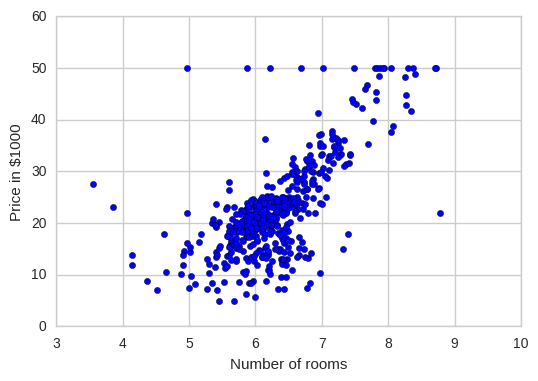

In [3]:
X, Y = DataFrame(data=boston.data, columns=boston.feature_names)[["ZN", "RM"]], DataFrame(data=boston.target, columns=["Price"])
plt.scatter(X["RM"], Y)
plt.xlabel("Number of rooms")
plt.ylabel("Price in $1000")

为了方便描述，我们这里引入一些符号。$x^{(i)}$ 用来表示输入变量，比如这里的平均房间数，它也被称为**特征features**。$y^{(i)}$ 用来表示输出变量，或我们希望预测的**目标target**变量。一对 $(x^{(i)}, y^{(i)})$ 称为一个**训练样本training example**，而我们将使用的 $m$ 个训练样本 $\{(x^{(i)}, y^{(i)});i=1,...,m\}$ 的集合称为**训练集training set**。注意这里的上标 $(i)$ 是对训练集的一个索引编号，不是幂运算。我们用 $\chi$ 表示输入空间，$\gamma$ 表示输出空间。在这个例子中 $\chi=\gamma=\mathbb{R}$

正式地定义监督学习：给定一个训练集，我们希望学习到一个函数 $h: \chi \rightarrow \gamma$，使得 $h(x)$ 可以很好地预测 $y$。由于历史原因，函数 $h$ 被称为**假设hypothesis**。

当我们希望预测的目标变量是连续型变量时，比如这里的房价，我们称这是一个**回归Regression**问题。当 $y$ 仅仅只取少数离散值时，我们称这是一个**分类Classification**问题。

# 线性回归 Linear Regression

包括以下内容：
    1. 最小二乘法 LMS algorithm
    2. 正规方程 The normal equations
    3. 概率诠释 Probabilistic interpretation
    4. 局部加权线性回归 Locally weighted linear regression

In [4]:
# 预览数据
print(X.join(Y).head())

     ZN     RM  Price
0  18.0  6.575   24.0
1   0.0  6.421   21.6
2   0.0  7.185   34.7
3   0.0  6.998   33.4
4   0.0  7.147   36.2


对于这个数据集，$x$ 是一个$\mathbb{R}^2$上的二维向量。例如 $x_1^i$ 是训练集中第 $i$ 个居住区域的超过25000平方英尺的居住用地区域占比，$x_2^i$是该区域的平均房间数。

要进行监督学习，我们需要首先决定如何来表示假设/函数 $h$。较为简单的情况下，我们选取 $x$ 的线性函数来预测 $y$ ：
$$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 $$
这里，$\theta_i$称为**参数parameters**（有时也称为**权重weights**），通过这组参数，我们将 $\chi$ 线性映射到 $\gamma$。在不引发误解的情况下，我们将 $h_\theta(x)$简写为 $h(x)$。习惯上，我们设 $x_0=1$ （称为**截距项intercept term**）,这样
$$ h(x) = \sum_{i=0}^n \theta_ix_i = \theta^Tx $$
对于右式，我们将 $\theta$ 和 $x$ 看做向量，$n$ 是特征数量（不包括 $x_0$ )

这样，给定训练集，我们需要挑选，或者说学习出参数 $\theta$ 的值。一个直观的方法是使 $h(x)$ 尽量接近 $y$，至少对于训练集来说，尽量地接近。为了更正式地定义“接近”，我们定义**成本函数cost function**：
$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2$$

## 1. 最小二乘法 Linear Regression

我们希望挑选出使 $J(\theta)$ 最小化的值 $\theta$。一种搜索算法的思路是，我们随机猜测一个 $\theta$，然后重复地改变 $\theta$ 使得 $J(\theta)$ 不断变小，直到 $\theta$ 收敛到某个值使得 $J(\theta)$ 取得最小值。

特别地，我们将考虑**梯度下降Gradient Descent**算法。如下图所示，$J(\theta)$ 是关于 $\theta_0$ 和 $\theta_1$ 的函数。首先我们随机选择一个 $ \theta = [3, 4]$，想象在图形中下坡，我们需要选择一个下降最快的方向。不断地前进，直到来到某个**局域最小值local minima**。在我们的图中，只有一个**全局最小值global minima**（以红星标记）。但梯度下降的一个特性是，当存在局域最小值时，根据随机选择初始化 $\theta$ 的不同，我们可能会到达不同的局域最小值。

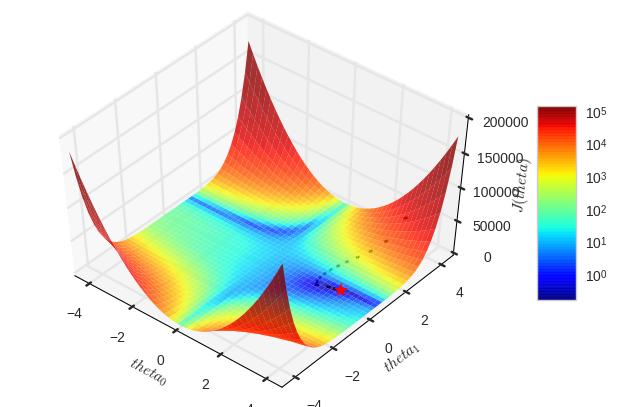

In [4]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d', elev=50, azim=-50)

# 生成数据，这里使用了Beale's function作为优化函数，可参考https://en.wikipedia.org/wiki/Test_functions_for_optimization
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2
x = np.arange(xmin, xmax + xstep, xstep)
y = np.arange(ymin, ymax + ystep, ystep)
x, y = np.meshgrid(x, y)
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
z = f(x, y)
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)

# surface平面图
surf = ax.plot_surface(x, y, z, norm=LogNorm(), cmap=cm.jet, rstride=1, cstride=1, edgecolor='none', alpha=.8)
# 最小值标记点
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

# 坐标名称
ax.set_xlabel('$theta_0$')
ax.set_ylabel('$theta_1$')
ax.set_zlabel('$J(theta)$')
# 坐标范围
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
# 颜色条
fig.colorbar(surf, shrink=0.5, aspect=5)

# 路径绘制
x0 = np.array([3., 4.])
func = value_and_grad(lambda args: f(*args))

def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

path_ = [x0]
res = minimize(func, x0=x0, method='Newton-CG', jac=True, tol=1e-20, callback=make_minimize_cb(path_))
path = np.array(path_).T
ax.quiver(path[0,:-1], path[1,:-1], f(*path[::,:-1]), 
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], f(*(path[::,1:]-path[::,:-1])), 
          color='k')

plt.show()

动画展现

In [6]:
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def animate(i):
    line.set_data(path[0,:i], path[1,:i])
    line.set_3d_properties(f(*path[::,:i]))
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    point.set_3d_properties(f(*path[::,i-1:i]))
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=path.shape[1], interval=100, repeat_delay=5, 
                               blit=True)

HTML(anim.to_html5_video())

下面以数学形式定义梯度下降，随机选择某个初始 $\theta$，之后重复以下更新：
$$ \theta_j = \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta) $$
（同时对所有值进行更新，$j = 0,...,n$）

这里，$\alpha$ 称为**学习速率learning rate**。这个算法非常自然地每次往J下降幅度最为陡峭的方向前进一小步。

假设只有一个样本 $(x, y)$：

$$\begin{equation}
\begin{split}
\frac{\partial}{\partial\theta_j}J(\theta) & = \frac{\partial}{\partial\theta_j}\frac{1}{2}(h_\theta(x) - y)^2 \\
 & = 2 \cdot \frac{1}{2}(h_\theta(x) - y) \cdot \frac{\partial}{\partial\theta_j}(h_\theta(x) - y) \\
 & = (h_\theta(x) - y) \cdot \frac{\partial}{\partial\theta_j}(\sum_{i=0}^{n}\theta_ix_i-y) \\
 & = (h_\theta(x) - y)x_j
\end{split}
\end{equation}$$

我们根据以下规则进行更新：
$$ \theta_j = \theta_j + \alpha(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)} $$

这个规则称为**最小二乘 LMS least mean square**，也被称为**Widrow-Hoff学习规则**。这一规则是符合直觉地，比如，我们更新的量级，与**误差项 error term** $(y^{(i)} - h_\theta(x^{(i)}))$成正比。

对于整个训练集来说，我们只要修改更新规则为：
$$ \theta_j = \theta_j + \alpha\sum_{i=1}^m(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)} （同时更新所有 j ）$$
重复直至 $\theta$ 收敛即可。

每次更新过程中都检查整个训练集，我们称这种算法为**批量梯度下降 batch gradient descent**。对于线性回归来说，成本函数只有唯一一个全局最小值，不存在局域最小值。也就是说，$J$ 是一个凸二次函数。梯度下降对于线性回归总能收敛（唯一的前提，学习速率 $\alpha$ 没有选得过大）。